# Mullti-task Learning on Cifar100 Dataset: A CNN Approach
- Name: Minh T. Nguyen, Peter Chen
- ECE 6524 - Final Project
- Date: 4/14/2023
- **Objective**: Build a MTL model for image classification.
    - Task 1: Normal class classification (100 Classes).
    - Task 2: Superclass classification (20 Classes).
    
- **To Do**:
    - Experience with Different Model Configuration: 
        - Optimizers
        - Regularization: Dropout

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow
import tensorflow as tf
from keras.datasets import cifar100
from keras.utils import np_utils, plot_model
from keras.layers import Input, Dropout, Flatten, Dense
from keras.applications.resnet import ResNet152, preprocess_input
from keras import Model

In [2]:
tf.version.VERSION

'2.11.0'

# 1. Data Visualization & Preprocessing

# 1.1 Data Visualization

In [3]:
# download data from Keras API
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 6s 0us/step


In [4]:
# check dataset size
print(f"X={X_train.shape}, y={y_train.shape}")
print(f"X={X_test.shape}, y={y_test.shape}")

X=(50000, 32, 32, 3), y=(50000, 1)
X=(10000, 32, 32, 3), y=(10000, 1)


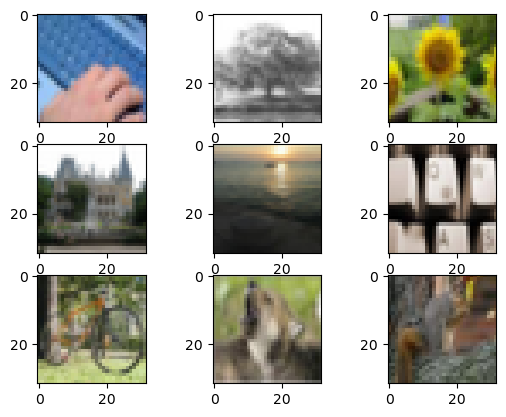

In [5]:
# plot the 9 images
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(X_train[10])
axarr[0,1].imshow(X_train[11])
axarr[0,2].imshow(X_train[12])
axarr[1,0].imshow(X_train[13])
axarr[1,1].imshow(X_train[14])
axarr[1,2].imshow(X_train[15])
axarr[2,0].imshow(X_train[16])
axarr[2,1].imshow(X_train[17])
axarr[2,2].imshow(X_train[18])
plt.show()

## 1.2. Creating Superclasses

**Superclass**
* aquatic mammals
* fish
* flowers
* food containers
* fruit and vegetables
* household electrical devices
* household furniture
* insects
* large carnivores
* large man-made outdoor things
* large natural outdoor scenes
* large omnivores and herbivores
* medium-sized mammals
* non-insect invertebrates
* people
* reptiles
* small mammals
* trees
* vehicles 1
* vehicles 2

In [6]:
# generate super-class of CIFAR100 dataset
(X_train_super, y_train_super), (X_test_super, y_test_super) = cifar100.load_data(label_mode = 'coarse')

In [7]:
# check labels for accuracy (referencing image plotted above)
print(y_train_super[10:19])

[[ 5]
 [17]
 [ 2]
 [ 9]
 [10]
 [ 5]
 [18]
 [ 8]
 [16]]


## 1.3. Data Processing

In [8]:
# normalize input data
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

# convert class into one hot encoder
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print('\ny_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

# convert class into one hot encoder
y_train_super = np_utils.to_categorical(y_train_super)
y_test_super = np_utils.to_categorical(y_test_super)

print('\ny_train_super shape: ', y_train_super.shape)
print('y_test_super shape: ', y_test_super.shape)

X_train shape:  (50000, 32, 32, 3)
X_test shape:  (10000, 32, 32, 3)

y_train shape:  (50000, 100)
y_test shape:  (10000, 100)

y_train_super shape:  (50000, 20)
y_test_super shape:  (10000, 20)


# 2. Modeling

In [9]:
# Define ResNet152 CNN model
def create_model(dropout):
    input_shape = (32, 32, 3)
    
    resnet152_base = ResNet152(weights=None, include_top=False, input_shape=input_shape)
    
    
    # shared back-bone: convolution - feature extractor
    inputs = Input(shape=input_shape, name='input')
    shared_branch = resnet152_base(inputs)
    shared_branch = Flatten()(shared_branch)
    shared_branch = Dense(2048, activation='relu')(shared_branch)
    
    # task 1 branch - fully connected for 100-class classification
    task_1_branch = Dense(1024, activation='relu')(shared_branch)
    task_1_branch = Dropout(dropout)(task_1_branch) 
    task_1_branch = Dense(512, activation="relu")(task_1_branch)
    task_1_branch = Dense(256, activation="relu")(task_1_branch)
    task_1_branch = Dense(128, activation="relu")(task_1_branch)
    task_1_branch = Dense(100, activation="softmax", name="task_1_output")(task_1_branch)
    
    # task 1 branch - fully connected for 20-class superclass classification
    task_2_branch = Dense(512, activation='relu')(shared_branch)
    task_2_branch = Dropout(dropout)(task_2_branch)
    task_2_branch = Dense(256, activation="relu")(task_2_branch)
    task_2_branch = Dense(128, activation="relu")(task_2_branch)
    task_2_branch = Dense(20, activation="softmax", name="task_2_output")(task_2_branch)
    
    # modeling
    model = Model(inputs=inputs, outputs=[task_1_branch, task_2_branch])
    
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resnet152 (Functional)         (None, 1, 1, 2048)   58370944    ['input[0][0]']                  
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['resnet152[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 2048)         4196352     ['flatten[0][0]']                
                                                                                              

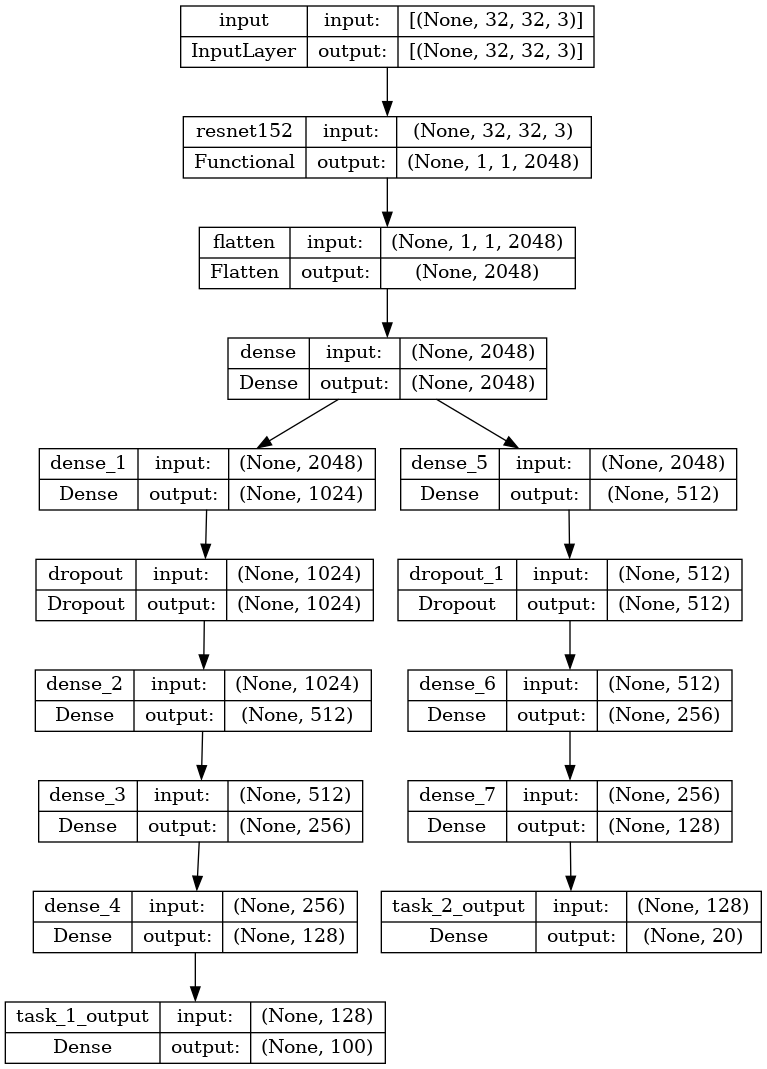

In [10]:
# display and plot model
model = create_model(0)
print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
# define number of epochs and batch size
epochs = 20
batch_size = 128

## 2.1. Case 1: Gamma = 0.5 - The model will receive the loss evenly in both tasks
##      (Dropout = 0, Optimizer = Adam)

In [12]:
# define parameters and generate model
gamma=0.5
dropout = 0
optimizer = 'Adam'
model_1 = create_model(dropout)

In [13]:
# compile model
model_1.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [14]:
# train model
history_1 = model_1.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
333/333 [==============================] - 156s 149ms/step - loss: 3.6416 - task_1_output_loss: 4.4290 - task_2_output_loss: 2.8542 - task_1_output_accuracy: 0.0229 - task_2_output_accuracy: 0.0972 - val_loss: 3.5496 - val_task_1_output_loss: 4.3285 - val_task_2_output_loss: 2.7707 - val_task_1_output_accuracy: 0.0259 - val_task_2_output_accuracy: 0.1059
Epoch 2/20
333/333 [==============================] - 46s 140ms/step - loss: 3.3831 - task_1_output_loss: 4.1487 - task_2_output_loss: 2.6175 - task_1_output_accuracy: 0.0390 - task_2_output_accuracy: 0.1534 - val_loss: 3.5398 - val_task_1_output_loss: 4.3139 - val_task_2_output_loss: 2.7657 - val_task_1_output_accuracy: 0.0285 - val_task_2_output_accuracy: 0.1192
Epoch 3/20
333/333 [==============================] - 46s 140ms/step - loss: 3.2704 - task_1_output_loss: 4.0303 - task_2_output_loss: 2.5104 - task_1_output_accuracy: 0.0483 - task_2_output_accuracy: 0.1899 - val_loss: 3.3346 - val_task_1_output_loss: 4.0708 - val

In [15]:
# train model results
print('Train loss:', history_1.history['loss'][-1])

print('\nTrain task 1 loss:', history_1.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_1.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_1.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_1.history['task_2_output_accuracy'][-1])

Train loss: 1.7982040643692017

Train task 1 loss: 2.3252787590026855
Train task 1 acc: 0.35508236289024353

Train task 2 loss: 1.2711288928985596
Train task 2 acc: 0.5882353186607361


### Evaluate Model

In [16]:
# test model results
evaluation_results = model_1.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [17]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 2.4221746921539307

Test task 1 loss: 3.045034408569336
Test task 1 acc: 0.27059999108314514

Test task 2 loss: 1.7993146181106567
Test task 2 acc: 0.4758000075817108


### Plot Results

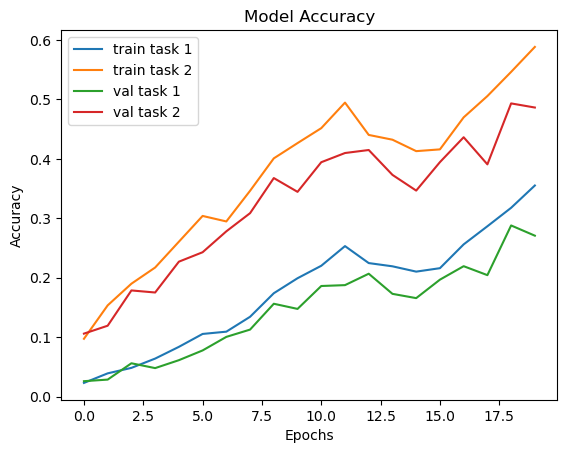

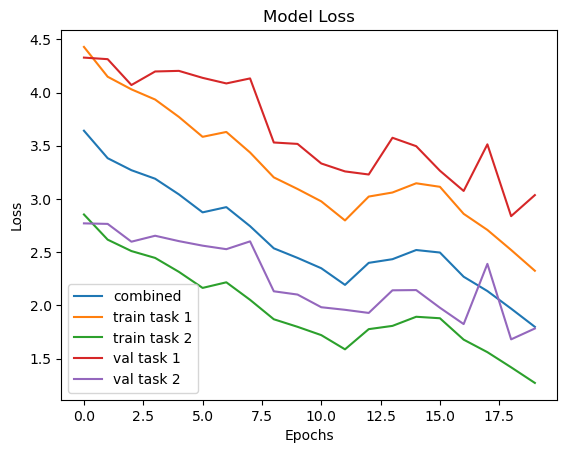

In [18]:
# accuracy plot
plt.plot(history_1.history['task_1_output_accuracy'])
plt.plot(history_1.history['task_2_output_accuracy'])
plt.plot(history_1.history['val_task_1_output_accuracy'])
plt.plot(history_1.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['task_1_output_loss'])
plt.plot(history_1.history['task_2_output_loss'])
plt.plot(history_1.history['val_task_1_output_loss'])
plt.plot(history_1.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.2. Case 2: Gamma = 0.6 - The model will receive loss 60% from task 1, 40% from task 2.
##      (Dropout = 0, Optimizer = Adam)

### Get Model

In [19]:
# define parameters and generate model
gamma=0.6
dropout = 0
optimizer = 'Adam'
model_2 = create_model(dropout)

In [20]:
# compile model
model_2.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [21]:
# train model
history_2 = model_2.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
333/333 [==============================] - 158s 159ms/step - loss: 3.8747 - task_1_output_loss: 4.5068 - task_2_output_loss: 2.9266 - task_1_output_accuracy: 0.0185 - task_2_output_accuracy: 0.0818 - val_loss: 4.0160 - val_task_1_output_loss: 4.6848 - val_task_2_output_loss: 3.0128 - val_task_1_output_accuracy: 0.0216 - val_task_2_output_accuracy: 0.0997
Epoch 2/20
333/333 [==============================] - 48s 143ms/step - loss: 3.6295 - task_1_output_loss: 4.2381 - task_2_output_loss: 2.7166 - task_1_output_accuracy: 0.0332 - task_2_output_accuracy: 0.1318 - val_loss: 3.7866 - val_task_1_output_loss: 4.4195 - val_task_2_output_loss: 2.8374 - val_task_1_output_accuracy: 0.0276 - val_task_2_output_accuracy: 0.1223
Epoch 3/20
333/333 [==============================] - 48s 143ms/step - loss: 3.4628 - task_1_output_loss: 4.0589 - task_2_output_loss: 2.5687 - task_1_output_accuracy: 0.0478 - task_2_output_accuracy: 0.1745 - val_loss: 3.9666 - val_task_1_output_loss: 4.6687 - val

In [22]:
# train model results
print('Train loss:', history_2.history['loss'][-1])

print('\nTrain task 1 loss:', history_2.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_2.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_2.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_2.history['task_2_output_accuracy'][-1])

Train loss: 1.961887001991272

Train task 1 loss: 2.3833725452423096
Train task 1 acc: 0.3485647141933441

Train task 2 loss: 1.3296585083007812
Train task 2 acc: 0.5741176605224609


### Evaluate Model

In [23]:
# test model results
evaluation_results = model_2.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [24]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 2.5404319763183594

Test task 1 loss: 3.031141519546509
Test task 1 acc: 0.243599995970726

Test task 2 loss: 1.8043668270111084
Test task 2 acc: 0.45019999146461487


### Plot Results

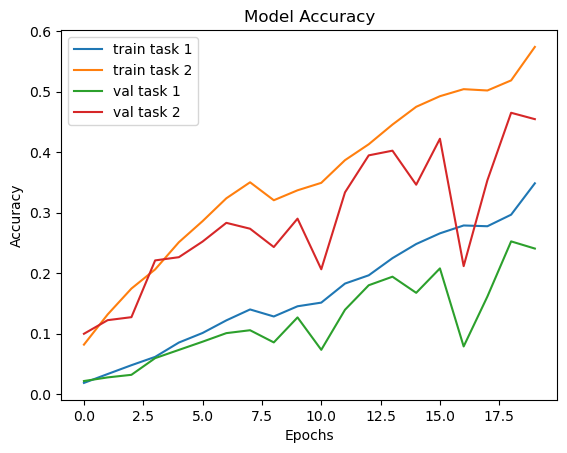

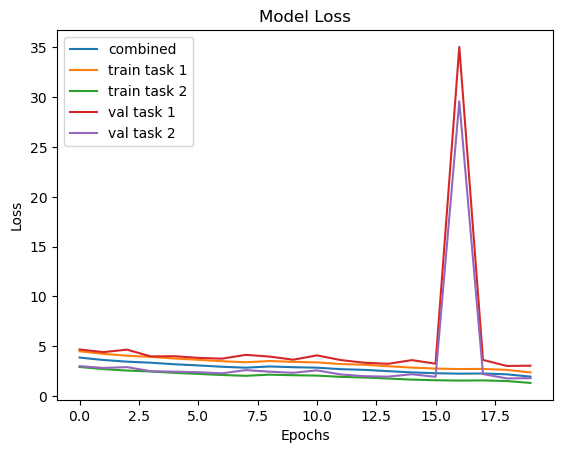

In [25]:
# accuracy plot
plt.plot(history_2.history['task_1_output_accuracy'])
plt.plot(history_2.history['task_2_output_accuracy'])
plt.plot(history_2.history['val_task_1_output_accuracy'])
plt.plot(history_2.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['task_1_output_loss'])
plt.plot(history_2.history['task_2_output_loss'])
plt.plot(history_2.history['val_task_1_output_loss'])
plt.plot(history_2.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.3. Case 3: Gamma = 0.4 - The model will receive loss 40% from task 1, 60% from task 2.
##      (Dropout = 0, Optimizer = Adam)

In [26]:
# define parameters and generate model
gamma=0.4
dropout = 0
optimizer = 'Adam'
model_3 = create_model(dropout)

In [27]:
# compile model
model_3.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [28]:
# train model
history_3 = model_3.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
333/333 [==============================] - 158s 160ms/step - loss: 3.5435 - task_1_output_loss: 4.4962 - task_2_output_loss: 2.9085 - task_1_output_accuracy: 0.0193 - task_2_output_accuracy: 0.0899 - val_loss: 3.7520 - val_task_1_output_loss: 4.7669 - val_task_2_output_loss: 3.0754 - val_task_1_output_accuracy: 0.0193 - val_task_2_output_accuracy: 0.0820
Epoch 2/20
333/333 [==============================] - 48s 144ms/step - loss: 3.2900 - task_1_output_loss: 4.2124 - task_2_output_loss: 2.6750 - task_1_output_accuracy: 0.0381 - task_2_output_accuracy: 0.1431 - val_loss: 3.3329 - val_task_1_output_loss: 4.2799 - val_task_2_output_loss: 2.7016 - val_task_1_output_accuracy: 0.0407 - val_task_2_output_accuracy: 0.1507
Epoch 3/20
333/333 [==============================] - 47s 143ms/step - loss: 3.0642 - task_1_output_loss: 3.9593 - task_2_output_loss: 2.4674 - task_1_output_accuracy: 0.0609 - task_2_output_accuracy: 0.2080 - val_loss: 3.2572 - val_task_1_output_loss: 4.1905 - val

In [29]:
# train model results
print('Train loss:', history_3.history['loss'][-1])

print('\nTrain task 1 loss:', history_3.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_3.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_3.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_3.history['task_2_output_accuracy'][-1])

Train loss: 1.8961222171783447

Train task 1 loss: 2.58193039894104
Train task 1 acc: 0.30896469950675964

Train task 2 loss: 1.4389159679412842
Train task 2 acc: 0.54569411277771


### Evaluate Model

In [30]:
# test model results
evaluation_results = model_3.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [31]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 2.2687997817993164

Test task 1 loss: 2.996802806854248
Test task 1 acc: 0.2513999938964844

Test task 2 loss: 1.7834632396697998
Test task 2 acc: 0.4657000005245209


### Plot Results

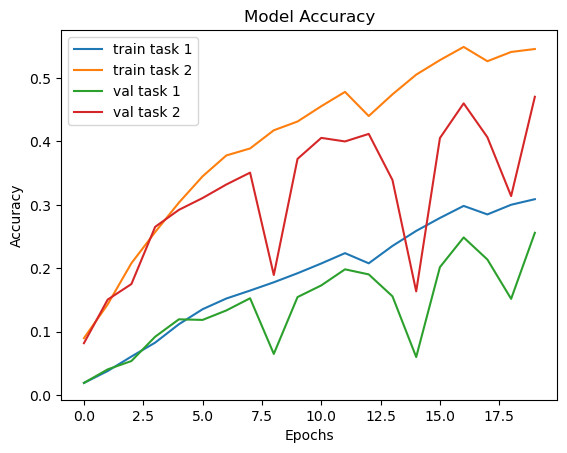

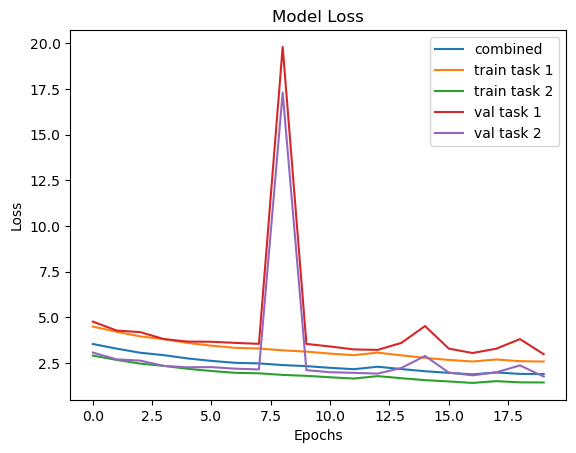

In [32]:
# accuracy plot
plt.plot(history_3.history['task_1_output_accuracy'])
plt.plot(history_3.history['task_2_output_accuracy'])
plt.plot(history_3.history['val_task_1_output_accuracy'])
plt.plot(history_3.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['task_1_output_loss'])
plt.plot(history_3.history['task_2_output_loss'])
plt.plot(history_3.history['val_task_1_output_loss'])
plt.plot(history_3.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.4. Case 4: Gamma = 0.4 - The model will receive loss 40% from task 1 and 60% task 2.
##      (Dropout = 0.4, Optimizer = Adam)

In [33]:
# define parameters and generate model
gamma=0.4
dropout = 0.4
optimizer = 'Adam'
model_4 = create_model(dropout)

In [34]:
# compile model
model_4.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [35]:
# train model
history_4 = model_4.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
333/333 [==============================] - 154s 152ms/step - loss: 3.5145 - task_1_output_loss: 4.4549 - task_2_output_loss: 2.8876 - task_1_output_accuracy: 0.0209 - task_2_output_accuracy: 0.0893 - val_loss: 3.3838 - val_task_1_output_loss: 4.3206 - val_task_2_output_loss: 2.7593 - val_task_1_output_accuracy: 0.0269 - val_task_2_output_accuracy: 0.1191
Epoch 2/20
333/333 [==============================] - 47s 141ms/step - loss: 3.2754 - task_1_output_loss: 4.1980 - task_2_output_loss: 2.6603 - task_1_output_accuracy: 0.0336 - task_2_output_accuracy: 0.1378 - val_loss: 3.4997 - val_task_1_output_loss: 4.4214 - val_task_2_output_loss: 2.8852 - val_task_1_output_accuracy: 0.0292 - val_task_2_output_accuracy: 0.1273
Epoch 3/20
333/333 [==============================] - 48s 143ms/step - loss: 3.1972 - task_1_output_loss: 4.1075 - task_2_output_loss: 2.5903 - task_1_output_accuracy: 0.0428 - task_2_output_accuracy: 0.1668 - val_loss: 3.5539 - val_task_1_output_loss: 4.5489 - val

In [36]:
# train model results
print('Train loss:', history_4.history['loss'][-1])

print('\nTrain task 1 loss:', history_4.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_4.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_4.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_4.history['task_2_output_accuracy'][-1])

Train loss: 2.4784820079803467

Train task 1 loss: 3.237126111984253
Train task 1 acc: 0.185082346200943

Train task 2 loss: 1.972718358039856
Train task 2 acc: 0.38070589303970337


### Evaluate Model

In [37]:
# test model results
evaluation_results = model_4.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [38]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 2.6397483348846436

Test task 1 loss: 3.4251270294189453
Test task 1 acc: 0.16519999504089355

Test task 2 loss: 2.1161606311798096
Test task 2 acc: 0.34929999709129333


### Plot Results

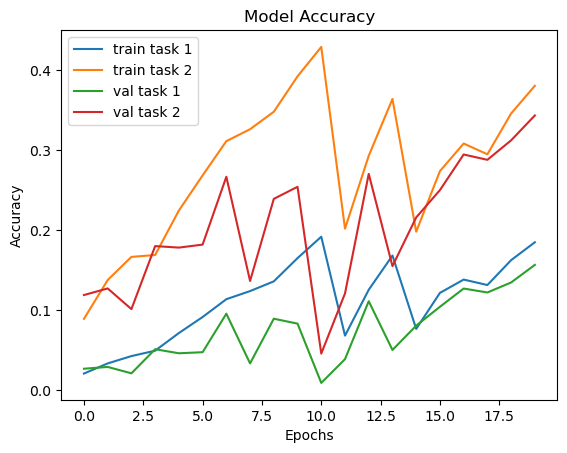

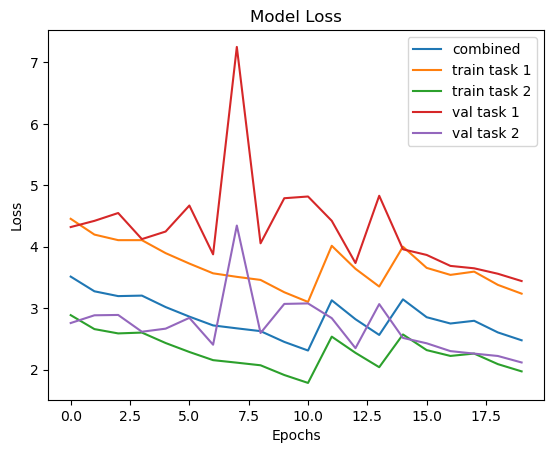

In [39]:
# accuracy plot
plt.plot(history_4.history['task_1_output_accuracy'])
plt.plot(history_4.history['task_2_output_accuracy'])
plt.plot(history_4.history['val_task_1_output_accuracy'])
plt.plot(history_4.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['task_1_output_loss'])
plt.plot(history_4.history['task_2_output_loss'])
plt.plot(history_4.history['val_task_1_output_loss'])
plt.plot(history_4.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.5. Case 5: Gamma = 0.4 - The model will receive loss 40% from task 1 and 60% task 2.
##      (Dropout = 0.4, Optimizer = SGD)

In [40]:
# define parameters and generate model
gamma=0.4
dropout = 0.4
optimizer = 'SGD'
model_5 = create_model(dropout)

In [41]:
# compile model
model_5.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'categorical_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer=optimizer,
              metrics=['accuracy'])

### Train & Evaluate Model

In [42]:
# train model
history_5 = model_5.fit({'input': X_train},
                        {'task_1_output': y_train, 'task_2_output': y_train_super}, 
                        validation_split=0.15,
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=1)

Epoch 1/20
333/333 [==============================] - 93s 145ms/step - loss: 3.6301 - task_1_output_loss: 4.6151 - task_2_output_loss: 2.9734 - task_1_output_accuracy: 0.0130 - task_2_output_accuracy: 0.0809 - val_loss: 199.1914 - val_task_1_output_loss: 208.9479 - val_task_2_output_loss: 192.6871 - val_task_1_output_accuracy: 0.0123 - val_task_2_output_accuracy: 0.0511
Epoch 2/20
333/333 [==============================] - 44s 134ms/step - loss: 3.4954 - task_1_output_loss: 4.5489 - task_2_output_loss: 2.7931 - task_1_output_accuracy: 0.0210 - task_2_output_accuracy: 0.1330 - val_loss: 13.9311 - val_task_1_output_loss: 15.1078 - val_task_2_output_loss: 13.1465 - val_task_1_output_accuracy: 0.0095 - val_task_2_output_accuracy: 0.0504
Epoch 3/20
333/333 [==============================] - 45s 136ms/step - loss: 3.4064 - task_1_output_loss: 4.4648 - task_2_output_loss: 2.7009 - task_1_output_accuracy: 0.0331 - task_2_output_accuracy: 0.1561 - val_loss: 4.1853 - val_task_1_output_loss: 5.13

In [43]:
# train model results
print('Train loss:', history_5.history['loss'][-1])

print('\nTrain task 1 loss:', history_5.history['task_1_output_loss'][-1])
print('Train task 1 acc:', history_5.history['task_1_output_accuracy'][-1])

print('\nTrain task 2 loss:', history_5.history['task_2_output_loss'][-1])
print('Train task 2 acc:', history_5.history['task_2_output_accuracy'][-1])

Train loss: 2.2481513023376465

Train task 1 loss: 3.0417516231536865
Train task 1 acc: 0.20105881989002228

Train task 2 loss: 1.7190823554992676
Train task 2 acc: 0.45284706354141235


### Evaluate Model

In [44]:
# test model results
evaluation_results = model_5.evaluate(
                        X_test, 
                        [y_test, y_test_super],
                        verbose=0)

In [45]:
# test model results
print('Test loss:', evaluation_results[0])

print('\nTest task 1 loss:', evaluation_results[1])
print('Test task 1 acc:', evaluation_results[3])

print('\nTest task 2 loss:', evaluation_results[2])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 3.2708852291107178

Test task 1 loss: 4.231666564941406
Test task 1 acc: 0.093299999833107

Test task 2 loss: 2.6303629875183105
Test task 2 acc: 0.25049999356269836


### Plot Results

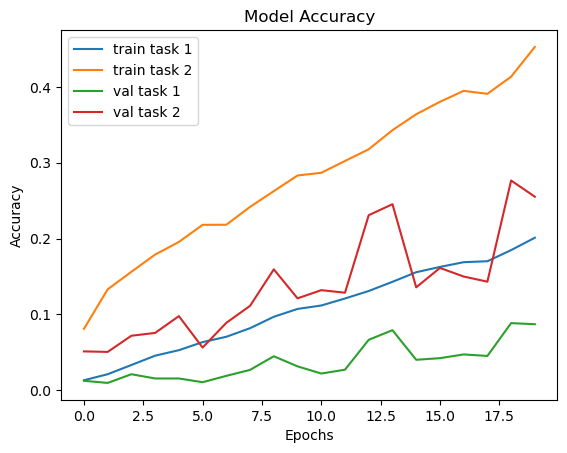

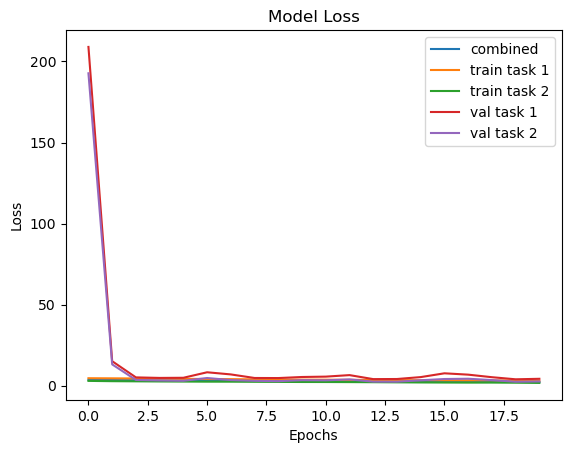

In [46]:
# accuracy plot
plt.plot(history_5.history['task_1_output_accuracy'])
plt.plot(history_5.history['task_2_output_accuracy'])
plt.plot(history_5.history['val_task_1_output_accuracy'])
plt.plot(history_5.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['task_1_output_loss'])
plt.plot(history_5.history['task_2_output_loss'])
plt.plot(history_5.history['val_task_1_output_loss'])
plt.plot(history_5.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()